In [1]:
import amici
import numpy as np
import pandas as pd
import os
from MARM.estimation import get_model, get_objective
from MARM.visualize import plot_and_save_fig
from MARM.paths import get_figure_dir

In [2]:
from MARM.pysb_flat.RTKERK__pRAF__EGF_MEKi_PRAFi_RAFi__ import model as pysb_model
from pysb.bng import generate_equations
generate_equations(pysb_model)

In [3]:
import matplotlib.pyplot as plt
PANDAS_FIGWIDTH = 15

In [4]:
model_name = 'RTKERK'
variant = 'pRAF'
dataset = 'EGF_EGFR_MEKi_PRAFi_RAFi'
model = get_model(model_name, variant, dataset)
objective = get_objective(model_name, variant, dataset, 1)
df = pd.concat([
    amici.getDataObservablesAsDataFrame(o.amici_model, o.edatas)
    for o in objective._objectives
])
figdir = get_figure_dir(model_name, variant, dataset)

In [5]:
# number of conditions
sum([len(o.edatas) for o in objective._objectives])

346

In [6]:
# transcriptomic data
df.loc[
    df.datatype=='data',
    [col for col in df.columns if col.endswith('_obs') and not col.endswith('IF_obs') and col.startswith('tm')]
].apply(np.isnan).apply(np.logical_not).sum(axis=0).sum()

45

In [7]:
# protemic data
df.loc[
    df.datatype=='data',
    [col for col in df.columns if col.endswith('_obs') and not col.endswith('IF_obs') and col.startswith('t') and not col.startswith('tm')]
].apply(np.isnan).apply(np.logical_not).sum(axis=0).sum()

55

In [8]:
# phosphoproteomic data
df.loc[
    df.datatype=='data',
    [col for col in df.columns if col.endswith('_obs') and not col.endswith('IF_obs') and col.startswith('p')]
].apply(np.isnan).apply(np.logical_not).sum(axis=0).sum()

10

In [9]:
# IF data
df.loc[
    df.datatype=='data',
    [col for col in df.columns if col.endswith('IF_obs')]
].apply(np.isnan).apply(np.logical_not).sum(axis=0).sum()

847

In [10]:
dataset = 'EGF_EGFR_MEKi_PRAFi_RAFi'
total_conditions = 0
total_datapoints = 0
for datafile in ['EGF_EGFR_MEKi_PRAFi_RAFi_singleprediction', 'EGF_EGFR_MEKi_PRAFi_RAFi_comboprediction',
                 'EGF_EGFR_MEKi_PRAFi_RAFi_panrafcomboprediction', 'EGF_EGFR_MEKi_PRAFi_RAFi_ht29',
                 'MEKi_PRAFi_RAFi_engineered_mutrasprediction', 'MEKi_PRAFi_RAFi_engineered_mutrascomboprediction']:
    objective = get_objective(model_name, variant, dataset, 1, datafile=datafile)
    df = pd.concat([
        amici.getDataObservablesAsDataFrame(o.amici_model, o.edatas)
        for o in objective._objectives
    ])
    n_data = df.loc[
        df.datatype=='data',
        [col for col in df.columns if col.endswith('IF_obs')]
    ].apply(np.isnan).apply(np.logical_not).sum(axis=0).sum()
    total_datapoints += n_data
    n_cond = sum([len(o.edatas) for o in objective._objectives])
    total_conditions += n_cond
    
print(f'total: {total_datapoints} datapoints in {total_conditions} conditions')

total: 2209 datapoints in 1647 conditions


In [11]:
from pysb.pattern import SpeciesPatternMatcher
spm = SpeciesPatternMatcher(pysb_model)
monomer_cross_counts = pd.DataFrame.from_dict({
    monomer1.name: {
        monomer2.name: 
        len(spm.match(monomer1() % monomer2())) / len(spm.match(monomer1())) * 100
        for monomer2 in pysb_model.monomers
        if not monomer2.name.startswith('m')
    }
    for monomer1 in pysb_model.monomers
    if not monomer1.name.startswith('m')
})

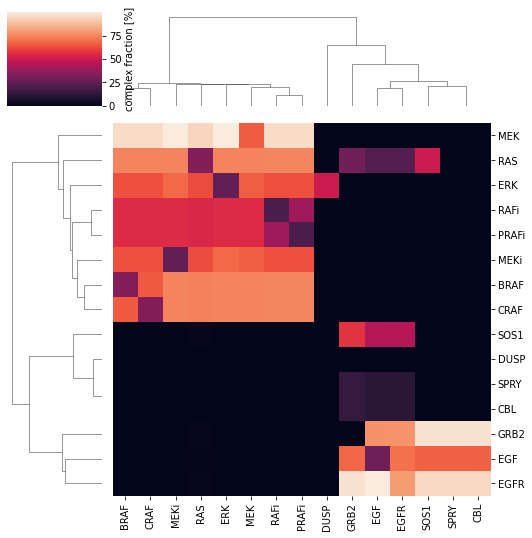

In [12]:
import seaborn as sns
ax = sns.clustermap(monomer_cross_counts,
                    figsize=(PANDAS_FIGWIDTH/2, PANDAS_FIGWIDTH/2),
                    cbar_kws={'label': 'complex fraction [%]'})
figdir = get_figure_dir(model_name, variant, dataset)
plot_and_save_fig(figdir, 'monomer_correlation.pdf')

In [13]:
def series_barchart(series, title, xf=1, ylog=False, ylim=None, yticks=None):
    colors = ['#C9C9C9', '#4F4F50']
    kwargs = {}
    if ylog:
        kwargs['bottom'] = ylim[0] if ylim else 0
    ax = series.plot.bar(
        rot=90, width=0.75, figsize=(3.0*xf, 3.0),
        color=colors[:len(series.shape)], stacked=True, legend=False,
        **kwargs
    )
    plt.text(0.99, 0.85, f'total: {series.sum().sum()}', 
             transform=ax.transAxes, ha='right')
    
    if ylog:
        plt.yscale('log')
        
    if yticks:
        plt.yticks(yticks)
        
    if ylim:
        plt.ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center');
    plot_and_save_fig(figdir, f'model_{title}.pdf')

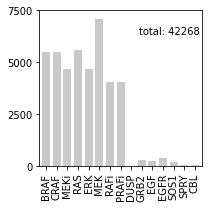

In [14]:
monomer_counts = pd.Series({
    monomer.name: len(spm.match(monomer()))
    for monomer in pysb_model.monomers
})
monomer_counts = monomer_counts.reindex([
    txt.get_text() for txt in ax.ax_heatmap.get_xticklabels()
])
series_barchart(monomer_counts, 'monomers', yticks=[0,2500,5000,7500])

In [15]:
monomer_counts

BRAF     5490
CRAF     5490
MEKi     4685
RAS      5576
ERK      4687
MEK      7064
RAFi     4061
PRAFi    4061
DUSP        2
GRB2      287
EGF       253
EGFR      360
SOS1      168
SPRY       42
CBL        42
dtype: int64

In [16]:
len(pysb_model.species)

7774

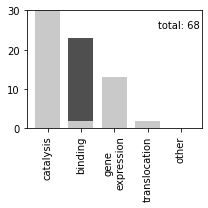

In [17]:
rule_names = [rule.name for rule in pysb_model.rules]

rule_filters = {
    'binding': lambda x: '_bind_' in x or 
                         '_binds_' in x or 
                         '_dissociates_from_' in x or
                         x.startswith('bind_'),
    'catalysis': lambda x: '_phosphorylates_' in x 
                        or '_is_phosphorylated' in x
                        or '_is_dephosphorylated' in x
                        or '_dephosphorylates_' in x
                        or '_guanosine_exchange' in x
                        or '_hydrolisis_' in x
                        or '_hydrolysis_' in x
                        or x.startswith('catalyze_'),
    'translocation': lambda x: '_is_endocytosed' in x
                            or '_is_recycled' in x,
    'gene\nexpression': lambda x: '_degradation_' in x 
                                  or '_degrades_' in x
                                  or 'synthesis_' in x
                                  or '_synthesizes_' in x
                                  or '_synthesis_' in x
                                  or x.endswith('_is_degraded'),
    'other': lambda x: False,
}

rule_filter_match_counts = {
    name: sum(rule_filter(name) for rule_filter in rule_filters.values())
    for name in rule_names
}

for count in rule_filter_match_counts.values():
    assert count == 1
    
df = pd.concat([
    pd.Series({
        filter_name: sum(rule_filter(x) and not pysb_model.rules[x].energy for x in rule_names)
        for filter_name, rule_filter in rule_filters.items()
    }),
    pd.Series({
        filter_name: sum(rule_filter(x) and pysb_model.rules[x].energy for x in rule_names)
        for filter_name, rule_filter in rule_filters.items()
    })
], axis=1, keys=['noenergy', 'energy'])

series_barchart(df.loc[list(df.sum(axis=1).sort_values(ascending=False).index
                            .values)],
                'rules',
                ylim=[0,30],
                yticks=[0,10,20,30])

In [18]:
df

,noenergy,energy
binding,2,21
catalysis,30,0
translocation,2,0
gene\nexpression,13,0
other,0,0


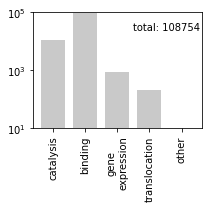

In [19]:
s = pd.Series({
    filter_name: sum(rule_filter(r['rule'][0])  for r in pysb_model.reactions)
    for filter_name, rule_filter in rule_filters.items()
})
series_barchart(s[list(df.sum(axis=1).sort_values(ascending=False).index
                       .values)],
                'reactions', 
                ylog=True,
                ylim=[1e1,1e5],
                yticks=[1e1,1e3,1e5])

In [20]:
s

binding             96874
catalysis           10827
translocation         200
gene\nexpression      853
other                   0
dtype: int64

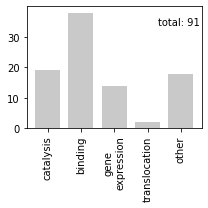

In [21]:
parameter_names = [parameter.name for parameter in pysb_model.parameters]
parameter_filters = {
    'binding': lambda x: x.endswith((
        'kD', 'kf', '_dG', '_ddG'
    )),
    'catalysis': lambda x: x.endswith((
        '_u_kcat', '_p_kcat', '_pS1134_kcat', '_pS642_kcat', 'pT753_kcat', 'gtp_kcat', 'kcatr', 'kbase', 'ub_kcat'
    )),
    'translocation': lambda x: x.endswith((
        'endo_kcat', 'recycl_kcat'
    )),
    'gene\nexpression': lambda x: x.endswith((
        'gexpslope', '_kdeg', '_deg_kcat', 'kM'
    )),
    'other': lambda x: x.endswith((
        'scale', 'offset', '_0', '_eq'
    )) and x not in ['RAFi_0', 'MEKi_0', 'PRAFi_0', 'EGF_0'],
}

parameter_filter_match_counts = {
    name: sum(parameter_filter(name) for parameter_filter in parameter_filters.values())
    for name in parameter_names
}
#check we are not missing anything/counting twice
for name, count in parameter_filter_match_counts.items():
    assert ( (count == 1) or ((
        name.endswith('phi') or 
        name in ['RAFi_0', 'PRAFi_0', 'MEKi_0', 'EGF_0', 'N_Avogadro', 'EGFR_crispr', 'volume', 'm_Da_EGF']
    ) and count == 0))
    
s = pd.Series({
    parameter_name: sum(parameter_filter(x) for x in parameter_names)
    for parameter_name, parameter_filter in parameter_filters.items()
}).sort_values(ascending=False)

series_barchart(s.loc[df.sum(axis=1).sort_values(ascending=False).index.values],
                'parameters',
                ylim=[0,40],
                yticks=[0,10,20,30])